# Feature Importance for adopted users
#### Marta Taulet - mtaulet@bu.edu

Given a dataset with details about the creation of 12,000 accounts, and a second dataset listing the days in which each user logged in to the product, the goal is to determine the features that make a user more likely to be an "adopted" user in the future. An "adopted" user is defined as a user that logs in to the product at least three times in a seven day period.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/Users/Marta/Documents/")
cwd = os.getcwd()
print(cwd)

/Users/Marta/Documents


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime as dt
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [3]:
from __future__ import division

# 1. Load dataset user data

In [4]:
df_userdata = pd.read_csv("data/takehome_users-intern_copy.csv", parse_dates=["creation_time"], infer_datetime_format=True)

In [5]:
df_userdata.shape

(12000, 10)

In [6]:
df_userdata = df_userdata.set_index("object_id")

In [7]:
df_userdata.head()

,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
object_id,,,,,,,,,
1,2014-04-22 03:53:00,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
2,2013-11-15 03:45:00,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
3,2013-03-19 23:14:00,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com
4,2013-05-21 08:09:00,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com
5,2013-01-17 10:14:00,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com


In [8]:
df_userdata.email.nunique()

11980

In [9]:
del df_userdata["email"]      # drop email column as it does not give useful information

In [10]:
df_userdata.dtypes

creation_time                 datetime64[ns]
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
email_domain                          object
dtype: object

# 2. Load user engagement data

In [11]:
df_user_engagement = pd.read_csv("data/takehome_user_engagement-intern.csv", parse_dates=["time_stamp"], infer_datetime_format=True)

In [12]:
df_user_engagement.shape

(207917, 3)

In [13]:
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:00,1,1
1,2013-11-15 03:45:00,2,1
2,2013-11-29 03:45:00,2,1
3,2013-12-09 03:45:00,2,1
4,2013-12-25 03:45:00,2,1


In [14]:
df_user_engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [15]:
del df_user_engagement["visited"]   # drop visited column as it does not give useful information

## 3: Label "adopted" users

In [16]:
df_userdata["adopted"] = 0          # Insert label column and initially populate with zeros

In [17]:
login_counts = df_user_engagement.user_id.value_counts()   # Number of logins for each user id
login_counts

3623     606
906      600
1811     593
7590     590
8068     585
9402     581
4022     580
3269     566
9312     547
7210     545
8029     541
2474     538
2658     526
8280     521
69       521
5297     520
4019     519
9083     517
2519     511
4263     509
3226     502
10599    501
6312     500
10953    499
8426     496
2316     496
603      489
2078     488
8768     487
445      487
        ... 
317        1
488        1
8633       1
10605      1
8556       1
10168      1
616        1
2665       1
2793       1
7359       1
872        1
11577      1
4842       1
5438       1
7487       1
9656       1
11705      1
1468       1
5566       1
3901       1
10861      1
11833      1
1596       1
5694       1
7743       1
6763       1
3773       1
5822       1
10040      1
2047       1
Name: user_id, Length: 8823, dtype: int64

In [18]:
potential_adopted_df = login_counts[login_counts >= 3].to_frame(name="n_logins")   # Filter by more than 3 logins in total
potential_adopted_df.head()

,n_logins
3623,606
906,600
1811,593
7590,590
8068,585


In [19]:
finalists_df = df_user_engagement[df_user_engagement["user_id"].isin(list(potential_adopted_df.index))]
finalists_df.head()

,time_stamp,user_id
1,2013-11-15 03:45:00,2
2,2013-11-29 03:45:00,2
3,2013-12-09 03:45:00,2
4,2013-12-25 03:45:00,2
5,2013-12-31 03:45:00,2


So far all users in the table have more than three logins. Now we want to check if each user has three entries in the same 7 day period.

In [20]:
for user, t in finalists_df.groupby("user_id"):
    for i in range(2, t.shape[0]):
        new_t = t.reset_index(drop=True)
        d = new_t.time_stamp[i] - new_t.time_stamp[i-2]  # Get the time difference between 3 logins
        if d < dt.timedelta(days=7):                     # If this difference is less than 7, the user is "adopted"
            df_userdata.ix[user, "adopted"] = 1
            break


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [21]:
df_userdata.adopted.value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

# 3: Feature importance

Identify categorical and numerical features

In [22]:
df_userdata.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,adopted
object_id,,,,,,,,,
1,2014-04-22 03:53:00,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com,0
2,2013-11-15 03:45:00,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com,1
3,2013-03-19 23:14:00,ORG_INVITE,1.363735e+09,0,0,94,1525.0,gustr.com,0
4,2013-05-21 08:09:00,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,yahoo.com,0
5,2013-01-17 10:14:00,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,yahoo.com,0


In [23]:
df_userdata.email_domain.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
mumdc.com            2
dqwln.com            2
xybhi.com            2
xvnbr.com            2
luque.com            2
oqpze.com            2
qgjbc.com            2
rerwl.com            2
urbci.com            1
bhisp.com            1
ajrkw.com            1
vsbbe.com            1
vgrpz.com            1
ysvxe.com            1
wschb.com            1
cmbwg.com            1
wpmpp.com            1
vflsd.com            1
tbvbu.com            1
gnxds.com            1
ynrub.com            1
wwrtt.com            1
cpugt.com            1
rtsgb.com            1
                  ... 
qkztw.com            1
ehwrq.com            1
llzow.com            1
ynsbd.com            1
xjdlv.com            1
cslyn.com            1
fiacj.com            1
cgdsi.com            1
iiqgf.com            1
wogms.com            1
nxcop.com            1
xgixs.com            1
djoqq.com  

In [24]:
sum(df_userdata.email_domain.value_counts() > 2)

6

There are only 6 dominant email domains, so we group the non-dominant in the "independent" group

In [25]:
dominant_domains = ["gmail.com", "yahoo.com", "jourrapide.com", "cuvox.de", "gustr.com", "hotmail.com"]

In [26]:
df_userdata.loc[~df_userdata.email_domain.isin(dominant_domains), "email_domain"] = "independent"

In [27]:
df_userdata.email_domain.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
independent       1186
gustr.com         1179
hotmail.com       1165
Name: email_domain, dtype: int64

### Encoding categorical variables

In [28]:
one_hot = pd.get_dummies(df_userdata['creation_source'])
df_encoded = df_userdata.drop(columns='creation_source')
df_encoded = df_encoded.join(one_hot)

In [29]:
df_encoded.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:00,1.398139e+09,1,0,11,10803.0,yahoo.com,0,1,0,0,0,0
2,2013-11-15 03:45:00,1.396238e+09,0,0,1,316.0,gustr.com,1,0,1,0,0,0
3,2013-03-19 23:14:00,1.363735e+09,0,0,94,1525.0,gustr.com,0,0,1,0,0,0
4,2013-05-21 08:09:00,1.369210e+09,0,0,1,5151.0,yahoo.com,0,1,0,0,0,0
5,2013-01-17 10:14:00,1.358850e+09,0,0,193,5240.0,yahoo.com,0,1,0,0,0,0


In [30]:
user_ids = df_userdata.invited_by_user_id.value_counts()

sum(user_ids >= 2)

1467

In [31]:
sum(user_ids < 2)

1097

In [32]:
one_hot = pd.get_dummies(df_encoded['email_domain'])
df_encoded = df_encoded.drop(columns="email_domain")
df_encoded = df_encoded.join(one_hot)

In [33]:
df_encoded.shape

(12000, 19)

In [34]:
df_encoded.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,cuvox.de,gmail.com,gustr.com,hotmail.com,independent,jourrapide.com,yahoo.com
object_id,,,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:00,1.398139e+09,1,0,11,10803.0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2013-11-15 03:45:00,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,2013-03-19 23:14:00,1.363735e+09,0,0,94,1525.0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,2013-05-21 08:09:00,1.369210e+09,0,0,1,5151.0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,2013-01-17 10:14:00,1.358850e+09,0,0,193,5240.0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [35]:
df_encoded["creation_year"] = df_userdata.creation_time.dt.year
df_encoded["creation_month"] = df_userdata.creation_time.dt.month
df_encoded["creation_day"] = df_userdata.creation_time.dt.day

In [36]:
del df_encoded["creation_time"]

In [37]:
df_encoded = df_encoded.fillna(0.0)

In [38]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 21 columns):
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted                       12000 non-null int64
GUEST_INVITE                  12000 non-null uint8
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
cuvox.de                      12000 non-null uint8
gmail.com                     12000 non-null uint8
gustr.com                     12000 non-null uint8
hotmail.com                   12000 non-null uint8
independent                   12000 non-null uint8
jourrapide.com                12000 non-null uint8
yahoo.com           

In [39]:
df_encoded.adopted.value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

In [40]:
y = df_encoded["adopted"]
X = df_encoded.drop(columns=["adopted", "last_session_creation_time"])

#### Approach 1: SelectKBest chi2

In [41]:
def select_k_best(X, y):
    bestfeatures = SelectKBest(score_func=chi2, k="all")
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Importance']
    print(featureScores.nlargest(10,'Importance')) 

In [42]:
select_k_best(X, y)

              Features    Importance
3   invited_by_user_id  26272.387638
2               org_id   5418.462606
6    PERSONAL_PROJECTS     56.844560
17      creation_month     36.162874
18        creation_day     20.319532
4         GUEST_INVITE     20.283149
15           yahoo.com     15.237361
8   SIGNUP_GOOGLE_AUTH     13.848040
12         hotmail.com     12.762762
10           gmail.com     11.048830


#### Approach 2: Random Forest Importances

In [43]:
def random_forest(X, y, k):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X, y)
    (pd.Series(model.feature_importances_, index=X.columns).nlargest(k).plot(kind='barh'))        # some method chaining, because it's sexy!

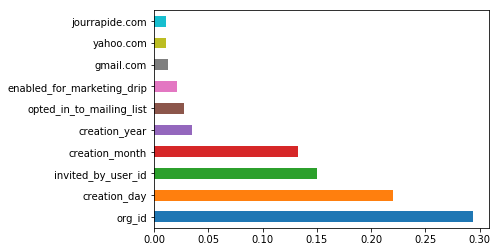

In [44]:
random_forest(X, y, 10)   # Run function three times to check that the results are consistent

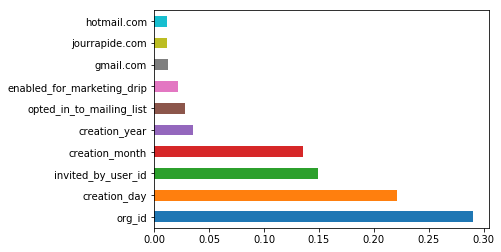

In [45]:
random_forest(X, y, 10)

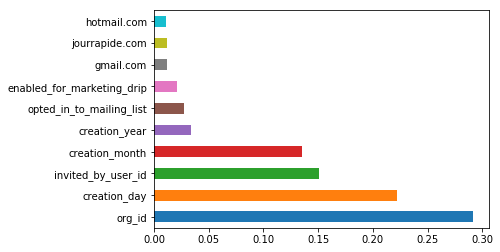

In [46]:
random_forest(X, y, 10)

# 4. Conclusions

As a combination of the results of the two previous methods, we will examine influences of following features:

- org_id
- creation_day
- creation_month
- creation_year
- invited_by_user_id
- PERSONAL_PROJECTS
- opted_in_to_mailing_list
- enabled_for_marketing_drip
- (extra) creation_source


In [47]:
def plot_feature(feat, k=500):
    ids = list(np.sort(np.unique(np.random.choice(df_encoded[feat].unique(), 500))))    
    adopted = list(map(lambda x : sum(df_userdata[df_encoded[feat] == x].adopted == 1), list(ids)))
    not_adopted = list(map(lambda x : sum(df_userdata[df_encoded[feat] == x].adopted == 0), list(ids)))
    total = list(map(lambda x : sum(df_userdata[df_encoded[feat] == x].adopted <= 1), list(ids)))
    
    
    plt.plot(ids, adopted, 'r', label="Adopted")
    plt.plot(ids, not_adopted, 'b', label="Not Adopted")
    plt.plot(ids, total, 'g', label="Total")
    legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
    plt.show()
    plt.plot(list(ids),[x/y for x, y in zip(adopted, total)], label="% Adopted")
    legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
    plt.show()
    
    if len([x/y for x, y in zip(adopted, total)]) <= 2:   # Display percenatges of binary features
        return "adopted/total = ",[x/y for x, y in zip(adopted, total)] 

In [48]:
df_userdata.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
6      138
5      128
9      124
7      119
10     104
8       97
14      87
11      75
12      75
17      74
18      73
13      72
16      72
20      68
15      64
24      63
25      62
28      61
23      60
30      59
22      58
33      57
40      57
21      56
27      55
      ... 
399     13
410     13
322     12
387     12
346     12
407     12
295     12
354     12
344     12
405     12
381     12
356     12
301     12
232     12
364     11
183     11
365     11
352     10
353     10
294     10
378     10
304     10
395      9
315      9
355      9
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

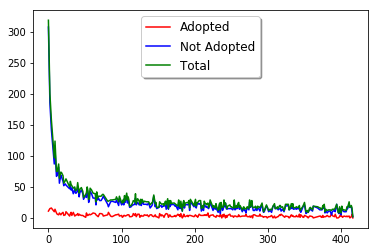

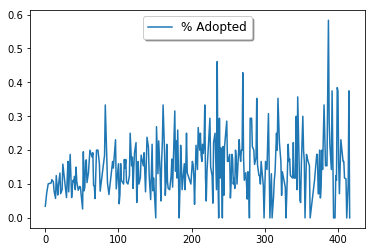

In [49]:
plot_feature("org_id")

Even though there are less high org_ids subscriptions than low ones, and the distribution has a high variance, in general the probability of accounts with high org_ids being "adopted" tends to be higher than low ids.

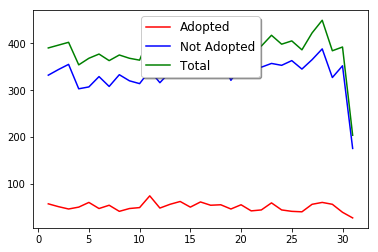

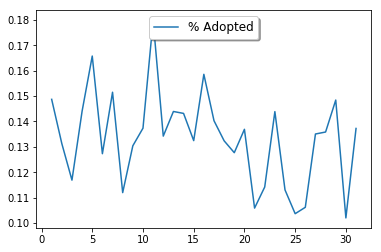

In [50]:
plot_feature("creation_day")

The day of the month had no clear trend but the data suggested a slightly higher probability of "adopted" users the first half of the month

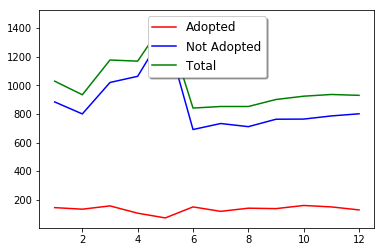

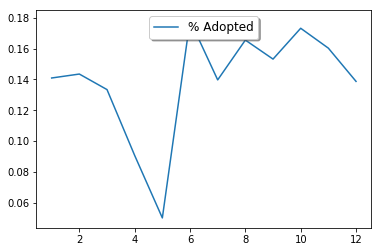

In [51]:
plot_feature("creation_month")

Although May was the month with more accounts created, it was also the month with less "adopted" users, so it is unlikely that May will result in high rate of adoption in the future

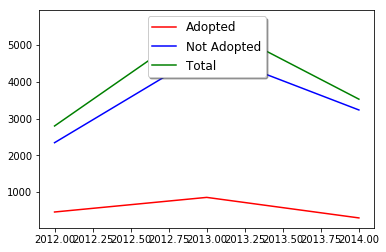

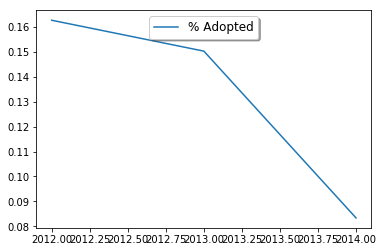

In [52]:
plot_feature("creation_year")

In [53]:
df_user_engagement.time_stamp.describe()

count                  207917
unique                 181047
top       2014-05-05 19:47:00
freq                        5
first     2012-05-31 08:20:00
last      2014-06-06 14:58:00
Name: time_stamp, dtype: object

The year data was considered not useful because, out of the three years on the record, the beginning of 2012 and the end of 2014 were missing. This led to strongly biased results.


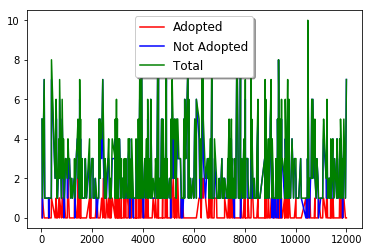

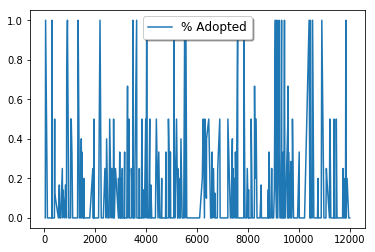

In [54]:
plot_feature("invited_by_user_id")

In [55]:
df_userdata.invited_by_user_id.value_counts()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
10628.0    10
7012.0     10
4612.0     10
4803.0     10
1175.0     10
8068.0     10
4302.0     10
2354.0     10
6370.0     10
10481.0    10
9434.0      9
9023.0      9
2922.0      9
4551.0      9
6645.0      9
7698.0      9
3789.0      9
3721.0      9
8554.0      9
3944.0      9
7716.0      9
6808.0      9
6493.0      9
8426.0      9
264.0       8
           ..
4885.0      1
5563.0      1
4231.0      1
3418.0      1
7837.0      1
3814.0      1
4655.0      1
10417.0     1
7979.0      1
5638.0      1
3422.0      1
6164.0      1
594.0       1
1750.0      1
6238.0      1
7425.0      1
5200.0      1
9325.0      1
4467.0      1
10335.0     1
7916.0      1
1945.0      1
11536.0     1
5989.0      1
11196.0     1
2746.0      1
10456.0     1
8371.0      1
6266.0      1
3572.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

The feature invited_by_user_id seemed to follow a uniform distribution with high variance so the results were not statistically significant

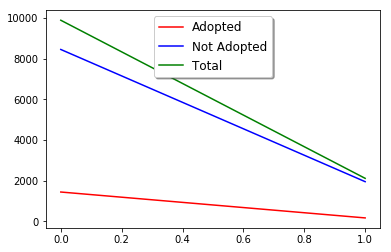

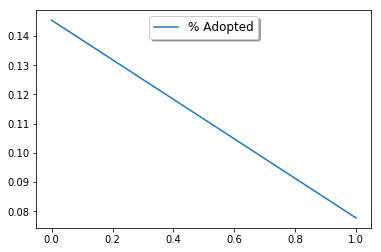

In [56]:
result = plot_feature("PERSONAL_PROJECTS")

In [57]:
result

('adopted/total = ', [0.14541409647082618, 0.07768829938417811])

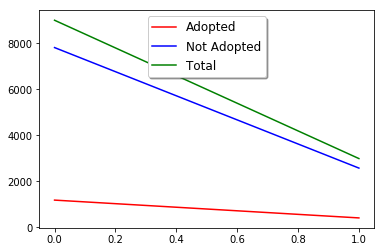

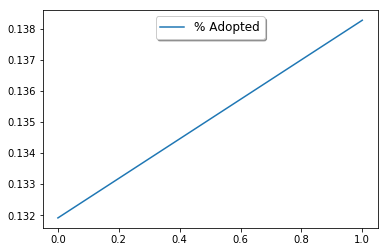

('adopted/total = ', [0.13191205862758162, 0.13827655310621242])

In [58]:
plot_feature("opted_in_to_mailing_list")

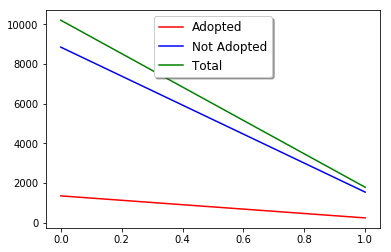

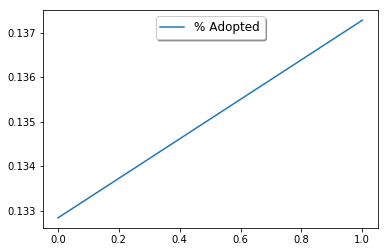

('adopted/total = ', [0.1328369905956113, 0.13727678571428573])

In [59]:
plot_feature("enabled_for_marketing_drip")

There was a higher chance of "adopted" users when they subscribed to mailing list as well as marketing drip but the difference was more pronounced in the mailing list case

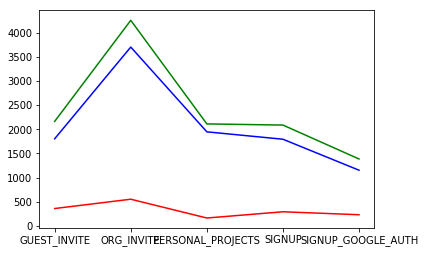

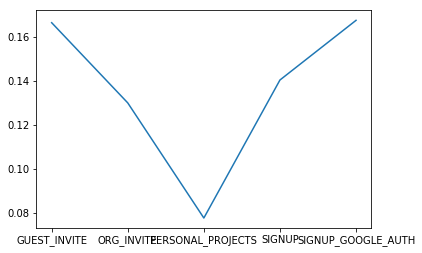

In [60]:
feat = "creation_source"
ids = list(np.sort(np.unique(np.random.choice(df_userdata[feat].unique(), 500))))    
adopted = list(map(lambda x : sum(df_userdata[df_userdata[feat] == x].adopted == 1), list(ids)))
not_adopted = list(map(lambda x : sum(df_userdata[df_userdata[feat] == x].adopted == 0), list(ids)))
total = list(map(lambda x : sum(df_userdata[df_userdata[feat] == x].adopted <= 1), list(ids)))

plt.plot(ids, adopted, 'r')
plt.plot(ids, not_adopted, 'b')
plt.plot(ids, total, 'g')
plt.show()
plt.plot(list(ids),[x/y for x, y in zip(adopted, total)])
plt.show()


Regarding creation source, guest invites and google signups led to higher adopted users and personal projects had the lowest adoption rates. That would imply that if a future user creates a personal project account the chances of them continuing to use the product for a long time are very low 